env: XLA_PYTHON_CLIENT_MEM_FRACTION=.2
# of training images:12000
# of test images:2000


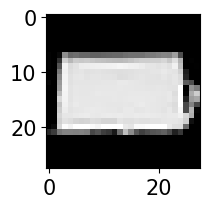

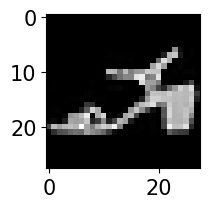

In [21]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.2

import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
import matplotlib.pyplot as plt
from jax import random
from scipy.linalg import circulant
from jax import grad, jit, vmap, value_and_grad
import optax
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

import os
import sys

file = open("../../../../meta.txt")
home = file.read().replace("\n", "/")
file.close()
    
p = os.path.abspath(home+'mypylib')
if p not in sys.path:
    sys.path.append(p)

import chunGP as gp
def getStepData(angles,thres=0):
    X=np.block([[np.cos(angles)],[np.sin(angles)]]).T
    Y=(np.sin(angles-np.pi/4)>=thres)[:,None]*2.0 - 1
    return X,Y
def get_tt(X,Y,train_ID):
    test_ID=np.invert(train_ID)
    x_train=X[train_ID,:]
    x_test=X[test_ID,:]
    y_train=Y[train_ID,:]
    y_test=Y[test_ID,:]
    return x_train,x_test,y_train,y_test


seed=100
np.random.seed(seed)


N=1000
P=500


labels=[5,8]#[6,9][5,8]
#labels=[8,9]#[7,9] #[0,1]

#angles=np.arange(N_total)
grayscale=False
All=False
#X,_,t_values,_,_,_,_,_,_,_=\
#    gp.getMNIST(N_train=N,N_test=100,normalize=True,seed=seed,labels=labels,All=All)
X,_,t_values,_,_,_,_,_,_,_=\
    gp.getFashion(N_train=N,N_test=100,normalize=True,seed=seed,labels=labels,All=All,home=home)
#X,_,t_values,_,_,_,_,_,_,_=\
#    gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,labels=labels,All=All,home=home)

#X=X-np.mean(X,axis=1)[:,None]
X=X/np.sqrt(np.sum(np.square(X),axis=1))[:,None]

Y = ( (t_values==labels[0])*1  - (t_values==labels[1])*1  )[:,None]

train_idx=np.random.choice(np.arange(N),P,replace=False)

train_ID=np.ones(N)==0
train_ID[train_idx]=True
test_ID=np.invert(train_ID)

x_train=X[train_ID,:]
x_test=X[test_ID,:]

y_train=Y[train_ID,:]
y_test=Y[test_ID,:]


fig,ax=plt.subplots(1,1,figsize=(2,2))
ax.imshow(X.reshape((-1,28,28))[1,:,:],cmap='gray')



In [22]:


####################################

alpha=P/N

resolution=100000000#100000000
trapz_n=10000
chunk_size=100000

m=0
Ls=jnp.arange(2,20)
pas=jnp.linspace(0.4999,0.01,20)
taus=gp.getTau(jnp.array(pas))
s0=0.0

VT=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N))
for j, tau in enumerate(taus):
    converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)
    #load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
    
    sigma=np.squeeze(gp.getosig(tau))
    load_names_te=gp.getSCK_fast_and_save(X,X,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')
        
    for g, L in enumerate(Ls):
    #try:
        #A=np.load(load_names_tr[g])
        K=np.load(load_names_te[g])
        
        Phi,lamb,_=jnp.linalg.svd(K)

        vteach=jnp.squeeze(jnp.matmul(Phi.T,Y))
        VT[j,g,:]=vteach
        
        del K
    del converter




loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel sav

9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done


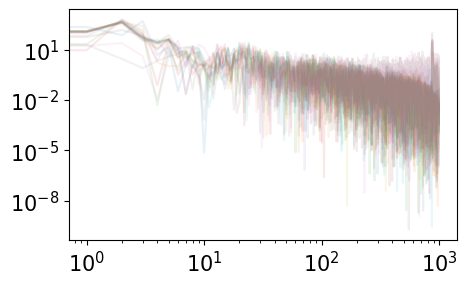

In [23]:
si=15
fig,ax=plt.subplots(1,1,figsize=(5,3))
for i in range(np.shape(Ls)[0]):
    ax.plot(np.square(VT[si,i,:]),label=i,alpha=0.1)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.legend()
